This notebook is to find an illustration for an extreme example that showcases why having different metrics for embedding and clustering affects the results.

We fix our embedding to be Node2Vec and therefore dot similarity. We use K-Means with different metrics as used in the previous notebook. We were worried about convergence issues, but we proceed hoping higher dimensions and sparser points will more likely lead to global maxima.

The protocol is to find a network with extremely stark embedding, and do clustering two ways and visualize the same K-Means results but with different metrics

### Choose a network

In [121]:
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Generate SBM Network
n_communities = 8
size = 2000
p_intra = 0.1
p_inter = 0.04
sizes = [size // n_communities] * n_communities
p_matrix = np.full((n_communities, n_communities), p_inter)
np.fill_diagonal(p_matrix, p_intra)

G = nx.stochastic_block_model(sizes, p_matrix)
true_labels = [i for i, s in enumerate(sizes) for _ in range(s)]

### Get Embeddings

In [122]:
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")
from scripts.nets_and_embeddings import *
emb = create_embedding(G, emb_params = {
                                    "method": "node2vec",
                                    "window_length": 10,
                                    "walk_length": 80, #30,
                                    "num_walks": 10, #200,
                                    "dim" : 64 #128,
                                        })



### Call K-Means Clustering from previous notebook
[For now, initialized in this notebook itself]

In [123]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

# Define distance metric functions
def euclidean_distance(X, centroids):
    return cdist(X, centroids, metric='euclidean')

def cosine_distance(X, centroids):
    return  - cosine_similarity(X, centroids)

def dot_distance(X, centroids):
    return -np.dot(X, centroids.T)

def manhattan_distance(X, centroids):
    return cdist(X, centroids, metric='cityblock')

def jaccard_distance(X, centroids):
    return cdist(X, centroids, metric='jaccard')

# Define a mapping from metric names to functions
distance_functions = {
    'euclidean': euclidean_distance,
    'cosine': cosine_distance,
    'dot': dot_distance,
    'manhattan': manhattan_distance,
    'jaccard': jaccard_distance
}

# Custom K-Means class
class CustomKMeans:
    def __init__(self, n_clusters=8, metric='euclidean', max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.metric = metric
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)
        self.centroids_ = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for i in range(self.max_iter):
            # Calculate distances using the selected metric
            distances = distance_functions[self.metric](X, self.centroids_)

            self.labels_ = np.argmin(distances, axis=1)
            
            # Ensure no empty clusters
            new_centroids = []
            for j in range(self.n_clusters):
                points_in_cluster = X[self.labels_ == j]
                if points_in_cluster.size == 0:
                    # Reassign centroid to a random point
                    new_centroids.append(X[np.random.choice(X.shape[0])])
                else:
                    new_centroids.append(points_in_cluster.mean(axis=0))
            
            new_centroids = np.array(new_centroids)
            
            # Check for convergence
            if np.all(self.centroids_ == new_centroids):
                break
            
            self.centroids_ = new_centroids
        
        return self

    def predict(self, X): 
        # Calculate distances using the selected metric
        distances = distance_functions[self.metric](X, self.centroids_)
        return np.argmin(distances, axis=1)

/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


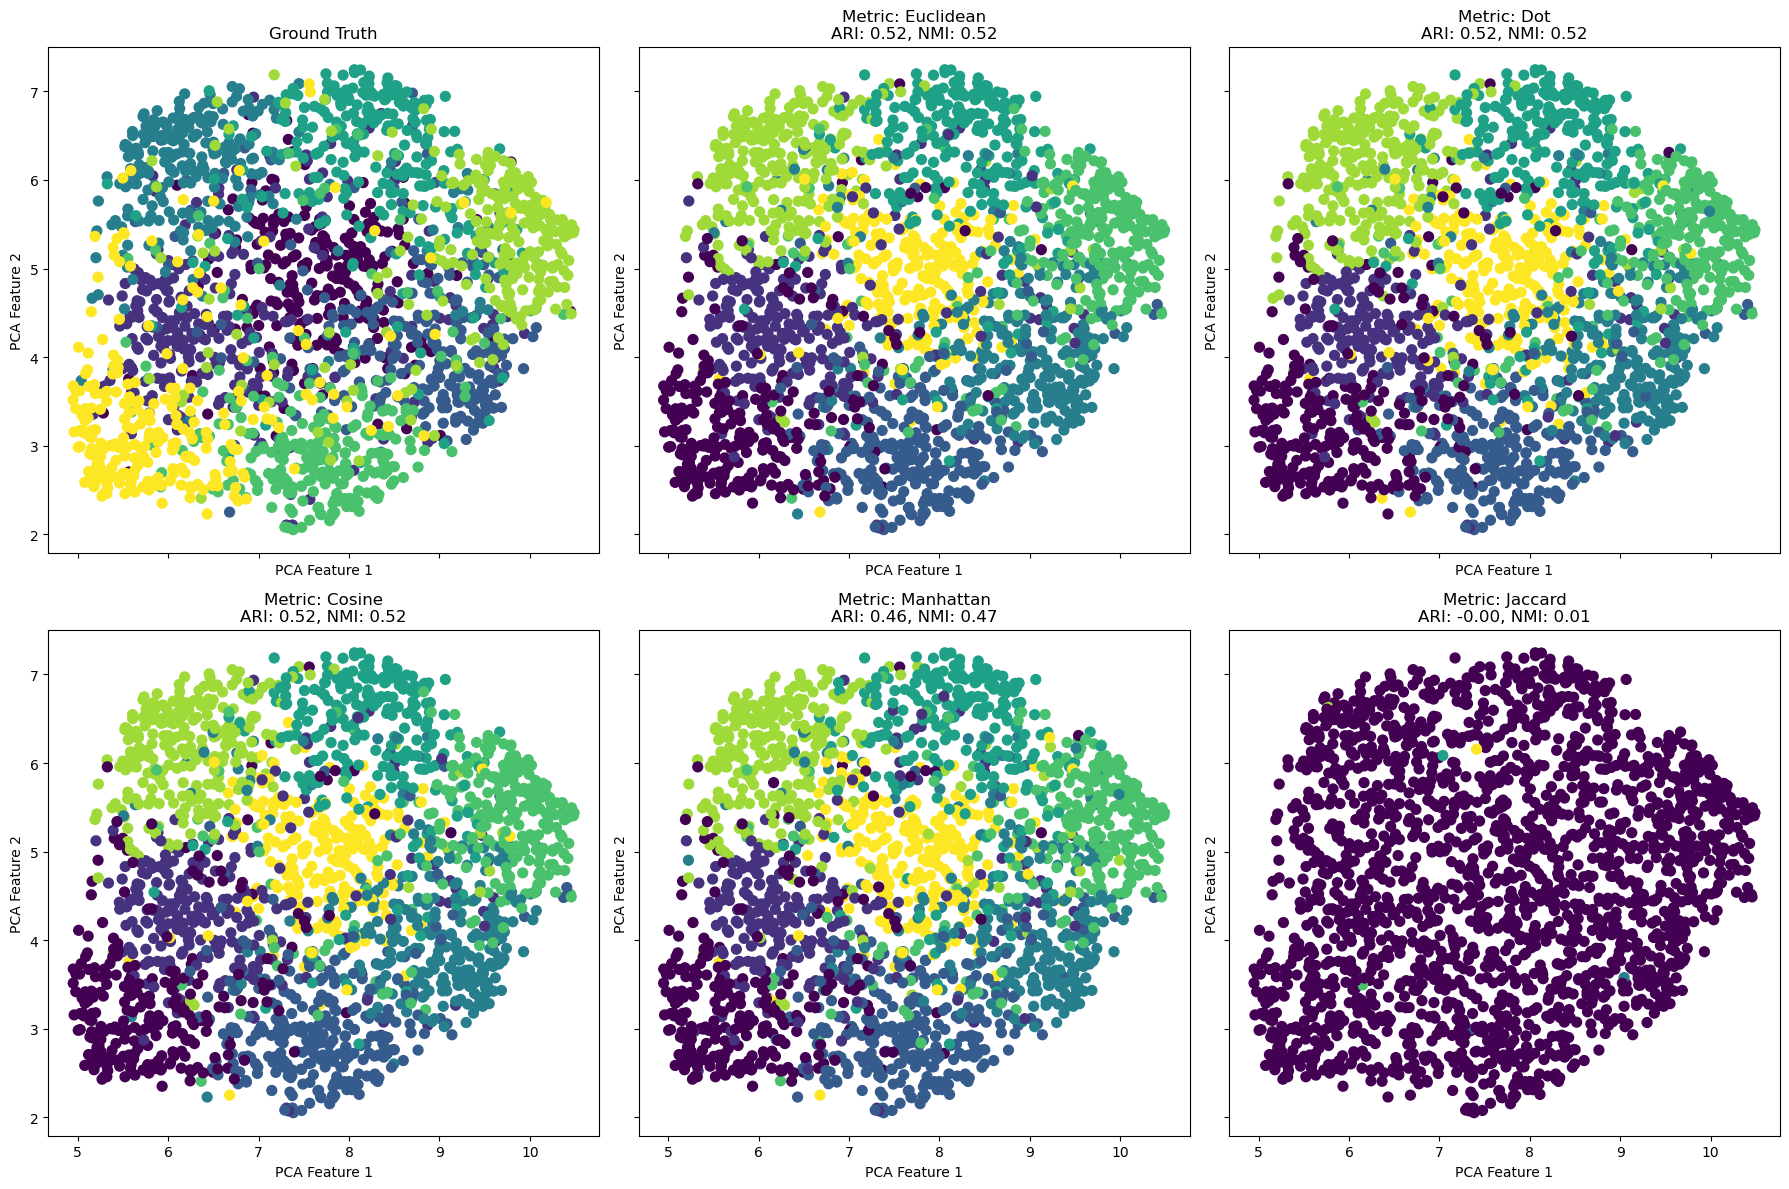

In [124]:
# Example usage:
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score, silhouette_score,normalized_mutual_info_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Initialize CustomKMeans with different metrics

metrics = ['euclidean', 'dot', 'cosine', 'manhattan', 'jaccard']
kmeans_models = {}


for metric in metrics:
    kmeans = CustomKMeans(n_clusters=n_communities, metric=metric, random_state=2)
    kmeans.fit(emb)
    kmeans_models[metric] = kmeans



# Reduce the dimensionality of embeddings to 2D using PCA
# PCA cuz it keeps it consistent and preserves global structure without adding stochasticity for easy comparison
# pca = PCA(n_components=2)
# emb_2d = pca.fit_transform(emb)

from sklearn.manifold import TSNE

# Reduce the dimensionality of embeddings to 2D using t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# emb_2d = tsne.fit_transform(emb)


umap_model = umap.UMAP(n_components=2, random_state=42)
emb_2d = umap_model.fit_transform(emb)
    
# Plot the results
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

#Ground truth plot
axes[0].scatter(emb_2d[:, 0], emb_2d[:, 1], c=true_labels, s=50, cmap='viridis')
axes[0].set_title('Ground Truth')
axes[0].set_xlabel('PCA Feature 1')
axes[0].set_ylabel('PCA Feature 2')

for i, metric in enumerate(metrics):
    y_pred = kmeans_models[metric].predict(emb)
    
    # Reduce centroids to 2D using PCA
    #centroids_2d = pca.transform(kmeans_models[metric].centroids_)

    # Calculate performance metrics
    ari = adjusted_rand_score(true_labels, y_pred)
    nmi  = normalized_mutual_info_score(true_labels, y_pred)
    
    
    axes[i+1].scatter(emb_2d[:, 0], emb_2d[:, 1], c=y_pred, s=50, cmap='viridis')
    #
    #axes[i+1].scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=200, c='red', marker='X')
    axes[i+1].set_title(f'Metric: {metric.capitalize()}\nARI: {ari:.2f}, NMI: {nmi:.2f}')
    axes[i+1].set_xlabel('PCA Feature 1')
    axes[i+1].set_ylabel('PCA Feature 2')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Why is it so similar to each other?